In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer,InputSpec
from keras.layers import Input
from keras.models import Model

K.set_image_dim_ordering("th")

class CylindricalPad(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalPad, self).__init__(**kwargs)
        self.n = n
        self.m = m
        #assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPad, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + 2*self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] + self.m,
                    input_shape[3] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + 2*self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] + self.m,
                    input_shape[3] + 2*self.n)
    
    def call(self,testElement, mask=None):
        firstColumns=testElement[:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,testElement.shape[3]-self.n:testElement.shape[3]]
        result=tf.concat([testElement,firstColumns], axis=3)
        result=tf.concat([lastColumns,result], axis=3)
        if self.m != 0 :
            #x = tf.placeholder(result.dtype, shape=[result.shape[0],result.shape[1],self.m,result.shape[3]])
            #y = tf.zeros_like(x,dtype=result.dtype)
            
            firstRows=result[:,:,0:self.m,:]
            
            #y = tf.fill(tf.shape(firstRows), 0.)
            sa=tf.shape(firstRows)[0]
            sb=tf.shape(firstRows)[1]
            sc=self.m
            sd=tf.shape(firstRows)[3]
            y = tf.fill([sa, sb,sc, sd], 0.)
            
            #y=tf.fill([result.shape[0],result.shape[1],self.m,result.shape[3]],0.)
            
            #y = tf.constant(0., shape=[result.shape[0],result.shape[1],self.m,result.shape[3]],dtype=result.dtype)
            result=tf.concat([y,result], axis=2)
            
            ########## only add 0's to de left for casusal pading
            #############result=tf.concat([result,y], axis=2)
        
        return result

    def get_config(self):
        config = {'n': self.n,
        'm': self.m}
        base_config = super(CylindricalPad, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

print("CylindricalPad class layer defined")


class CNN:
    @staticmethod
    def build(timeSteps,variables,classes):
        
        inputNet = Input(shape=(1,timeSteps,variables)) 
        
        conv1=CylindricalPad(m=0,n=2)(inputNet)
        conv1=Conv2D(10, (3,5), padding="valid")(conv1)
        conv1=AveragePooling2D(pool_size=(2, 1), strides=(2, 1))(conv1)
        conv1=Dropout(0.05)(conv1)
        conv2=CylindricalPad(m=0,n=2)(conv1)
        conv2=Conv2D(10,(3,5), padding="valid")(conv2)
        conv2=AveragePooling2D(pool_size=(2, 1), strides=(2, 1))(conv2)
        out1=Dropout(0.05)(conv2)
        flat=Flatten()(out1)
        denselayers=Dense(150)(flat)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.15)(denselayers)
        denselayers=Dense(50)(denselayers)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.15)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(classes)(denselayers)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model


In [ ]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split


def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('windows-pm2.5-size168-step24-norm.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size168-step24-pm2.5.csv',header=None)  #output classes 

total_inputs,total_output = dfin.as_matrix().astype(np.float32),dfout.as_matrix().astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,168,8))
print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
#train_inputs, test_inputs, train_output, test_output = train_test_split(total_inputs, total_output, test_size=0.20, random_state=42)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)




In [3]:
import numpy as np
IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs[:, np.newaxis, :, :]
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs[:, np.newaxis, :, :]
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = CNN.build(timeSteps=IMG_ROWS,variables=IMG_COLS,classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(575, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 72, 8)          0         
_________________________________________________________________
cylindrical_pad_1 (Cylindric (None, 1, 72, 12)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 70, 8)         160       
_________________________________________________________________
average_pooling2d_1 (Average (None, 10, 35, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 35, 8)         0         
_________________________________________________________________
cylindrical_pad_2 (Cylindric (None, 10, 35, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 33, 8)         1510      
_

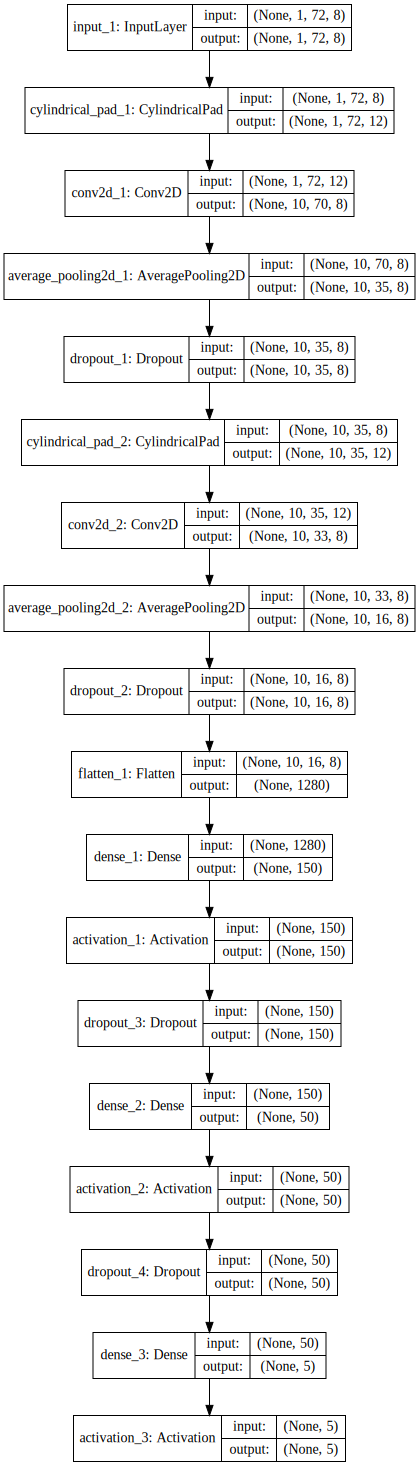

In [4]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [5]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('CNN-ROLL-poultion.h5', monitor='val_acc', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[reduce_lr,best_checkpoint])

Train on 2301 samples, validate on 575 samples
Epoch 1/100
2301/2301 [==============================] - 3s 1ms/step - loss: 1.5104 - acc: 0.3077 - val_loss: 1.4213 - val_acc: 0.3374

Epoch 00001: val_acc improved from -inf to 0.33739, saving model to CNN-ROLL-poultion.h5
Epoch 2/100
2301/2301 [==============================] - 0s 121us/step - loss: 1.4349 - acc: 0.3585 - val_loss: 1.4488 - val_acc: 0.2991

Epoch 00002: val_acc did not improve from 0.33739
Epoch 3/100
2301/2301 [==============================] - 0s 124us/step - loss: 1.3937 - acc: 0.3872 - val_loss: 1.3737 - val_acc: 0.3809

Epoch 00003: val_acc improved from 0.33739 to 0.38087, saving model to CNN-ROLL-poultion.h5
Epoch 4/100
2301/2301 [==============================] - 0s 128us/step - loss: 1.3679 - acc: 0.4085 - val_loss: 1.3684 - val_acc: 0.3722

Epoch 00004: val_acc did not improve from 0.38087
Epoch 5/100
2301/2301 [==============================] - 0s 119us/step - loss: 1.3509 - acc: 0.4081 - val_loss: 1.3793 - v

2301/2301 [==============================] - 0s 120us/step - loss: 1.2067 - acc: 0.4924 - val_loss: 1.3433 - val_acc: 0.3983

Epoch 00043: val_acc did not improve from 0.42261
Epoch 44/100
2301/2301 [==============================] - 0s 119us/step - loss: 1.2063 - acc: 0.4885 - val_loss: 1.3434 - val_acc: 0.4035

Epoch 00044: val_acc did not improve from 0.42261
Epoch 45/100
2301/2301 [==============================] - 0s 125us/step - loss: 1.2083 - acc: 0.4846 - val_loss: 1.3397 - val_acc: 0.4035

Epoch 00045: val_acc did not improve from 0.42261
Epoch 46/100
2301/2301 [==============================] - 0s 123us/step - loss: 1.1993 - acc: 0.4894 - val_loss: 1.3582 - val_acc: 0.4017

Epoch 00046: val_acc did not improve from 0.42261
Epoch 47/100
2301/2301 [==============================] - 0s 124us/step - loss: 1.1959 - acc: 0.4980 - val_loss: 1.3527 - val_acc: 0.3930

Epoch 00047: val_acc did not improve from 0.42261
Epoch 48/100
2301/2301 [==============================] - 0s 124us/s

In [6]:
import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n


saveHist('CNN-ROLL-polution.hist',history)
hist=loadHist('CNN-ROLL-polution.hist')




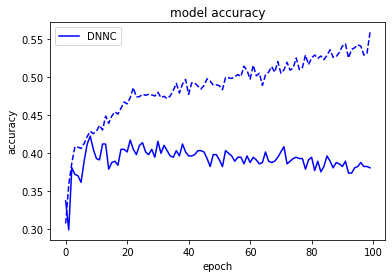

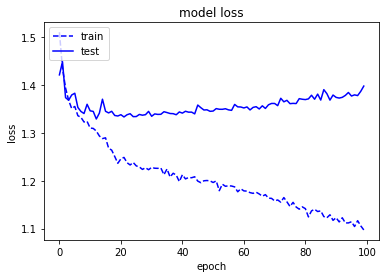

In [7]:
import matplotlib.pylab as plt

acc=np.array(hist['acc'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_acc'],'b',label='DNNC')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()